In [116]:
# pIDs = [12, 14:17, 19:21] ; %1:10; % remove also 18 1

pID = 12
pID = 'sub-' + "%03d" % (pID)

In [117]:
import os

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC

from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io
from bci_funcs import windowed_mean, base_correct, select_mean, slope

path = '/Volumes/Lukas_Gehrke/fastReach/data/eeglab2python'
# path = 'P:\\Lukas_Gehrke\\fastReach\\data\\eeglab2python'

# Preconscious Augmentation

This script trains the classifier for a brain-computer interface that controls electrical muscle stimulation in the preconscious augmentation experiment.
The functions used to build the feature vectors are the same that are used for the online application and are found in 'bci_funcs'

A two class linear discriminant model is fitted to idle and pre-movement EEG training data. The model and a channel selection is saved.

In [118]:
# load data
pre_move = scipy.io.loadmat(path+os.sep+pID+os.sep+'pre_move_Baseline.mat')
idle = scipy.io.loadmat(path+os.sep+pID+os.sep+'idle_Baseline.mat')
all_idle = idle['idle']
all_pre_move = pre_move['pre_move']

# Compute Features & Model fitting

In [119]:
nr_chans_arr = np.arange(2,21,2) # select one and then save the model

data_srate = 250
windows = 10
baseline = data_srate/windows

chan_names = pd.read_csv(path+os.sep+pID+os.sep+'sel_chans_names.csv')
all_chans = pd.read_csv(path+os.sep+pID+os.sep+'sel_chans.csv', header=None)

feat = 'slope' # slope or slope_2d

for nr_chans in nr_chans_arr:
    print(str(nr_chans) + ' channels')

    chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
    # print(chan_names.Var1[chans])

    idle = all_idle[chans, :, :]
    pre_move = all_pre_move[chans, :, :]

    if feat == 'slope':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0]))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]))

    elif feat == 'slope2d':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0]*2))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]*2))

    elif feat == 'windowed_means':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

    for trial_ix in range(0, pre_move.shape[2]):
        if feat == 'slope':
            pre_move_feat[trial_ix, :] = slope(pre_move[:,:,trial_ix], 'linear').flatten()
        
        elif feat == 'slope2d':
            pre_move_feat[trial_ix, :idle.shape[0]] = slope(pre_move[:,:150,trial_ix], 'linear').flatten()
            pre_move_feat[trial_ix, idle.shape[0]:] = slope(pre_move[:,150:,trial_ix], 'linear').flatten()

        elif feat == 'windowed_means':
            tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
            pre_move_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

    for trial_ix in range(0, idle.shape[2]):
        if feat == 'slope':
            idle_feat[trial_ix, :] = slope(idle[:,:,trial_ix], 'linear').flatten()    
        
        elif feat == 'slope2d':
            idle_feat[trial_ix, :idle.shape[0]] = slope(idle[:,:150,trial_ix], 'linear').flatten()
            idle_feat[trial_ix, idle.shape[0]:] = slope(idle[:,150:,trial_ix], 'linear').flatten()

        elif feat == 'windowed_means':
            tmp = base_correct(idle[:,:,trial_ix], baseline-1)
            idle_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

    data = np.concatenate((pre_move_feat, idle_feat), axis = 0)
    pre_move_class = np.ones((pre_move_feat.shape[0], 1))
    idle_class = np.zeros((idle_feat.shape[0], 1))
    classes = np.concatenate((pre_move_class, idle_class)).ravel()

    clf = LDA(solver='eigen', shrinkage='auto')
    clf.fit(data, classes)
    kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = ABC()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("ABC accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = QDA()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("QDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = RFC()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("RFC accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

2 channels
LDA accuracy: 0.6868945868945869 +/- 0.08598326470352369
4 channels
LDA accuracy: 0.6866096866096866 +/- 0.17997040725925637
6 channels
LDA accuracy: 0.6789173789173789 +/- 0.18840634844699045
8 channels
LDA accuracy: 0.6712250712250711 +/- 0.17882208433603416
10 channels
LDA accuracy: 0.6794871794871795 +/- 0.1603333148806511
12 channels
LDA accuracy: 0.6641025641025641 +/- 0.16021024976218776
14 channels
LDA accuracy: 0.6641025641025641 +/- 0.15835279647840528
16 channels
LDA accuracy: 0.6484330484330485 +/- 0.12590658731758878
18 channels
LDA accuracy: 0.649002849002849 +/- 0.13578300951699704
20 channels
LDA accuracy: 0.6410256410256411 +/- 0.17333788493492894


# Real-time Detection

8 channels
LDA accuracy: 0.6712250712250711 +/- 0.17882208433603416


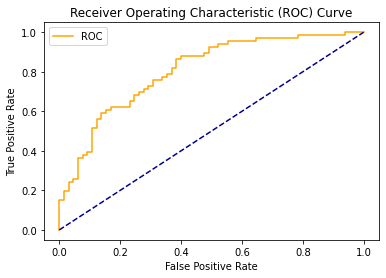

Threshold value is: 0.3592759449141896
F1 Score: 0.7164179104477613
Threshold used is: 0.6109255404888955


In [123]:
if pID == 'sub-012':
    nr_chans = 6
elif pID == 'sub-014':
    nr_chans = 16
elif pID == 'sub-015':
    nr_chans = 8
elif pID == 'sub-016':
    nr_chans = 14
elif pID == 'sub-017':
    nr_chans = 10
elif pID == 'sub-019':
    nr_chans = 14
elif pID == 'sub-020':
    nr_chans = 16
elif pID == 'sub-021':
    nr_chans = 8

target_class = 1.0
classifier_update_rate = .05 # update every 50 ms

### COPY IN WHERE BEST CLASSIFICATION PERFORMANCE WAS ACHIEVED ###

print(str(nr_chans) + ' channels')

chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
# print(chan_names.Var1[chans])

idle = all_idle[chans, :, :]
pre_move = all_pre_move[chans, :, :]

if feat == 'slope':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0]))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]))

elif feat == 'slope2d':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0]*2))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]*2))

elif feat == 'windowed_means':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

for trial_ix in range(0, pre_move.shape[2]):
    if feat == 'slope':
        pre_move_feat[trial_ix, :] = slope(pre_move[:,:,trial_ix], 'linear').flatten()
    
    elif feat == 'slope2d':
        pre_move_feat[trial_ix, :idle.shape[0]] = slope(pre_move[:,:150,trial_ix], 'linear').flatten()
        pre_move_feat[trial_ix, idle.shape[0]:] = slope(pre_move[:,150:,trial_ix], 'linear').flatten()

    elif feat == 'windowed_means':
        tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
        pre_move_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

for trial_ix in range(0, idle.shape[2]):
    if feat == 'slope':
        idle_feat[trial_ix, :] = slope(idle[:,:,trial_ix], 'linear').flatten()    
    
    elif feat == 'slope2d':
        idle_feat[trial_ix, :idle.shape[0]] = slope(idle[:,:150,trial_ix], 'linear').flatten()
        idle_feat[trial_ix, idle.shape[0]:] = slope(idle[:,150:,trial_ix], 'linear').flatten()

    elif feat == 'windowed_means':
        tmp = base_correct(idle[:,:,trial_ix], baseline-1)
        idle_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

data = np.concatenate((pre_move_feat, idle_feat), axis = 0)
pre_move_class = np.ones((pre_move_feat.shape[0], 1))
idle_class = np.zeros((idle_feat.shape[0], 1))
classes = np.concatenate((pre_move_class, idle_class)).ravel()

clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)
kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
acc = cv_results.mean()
acc_std = cv_results.std()
print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))
### END ###

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def interp_roc_curve(true, score, by ='fp', byval = np.linspace(0,1,101)):
    fp, tp, th =  roc_curve(true, score)
    data = {'fp': fp, 'tp': tp, 'th': th}
    interpData = {}
    for k,v in data.items():
        if k==by:
            interpData[k] = byval
        else:
            interpData[k] = np.interp(byval, data[by], data[k])
    roc = pd.DataFrame.from_dict(interpData)
    return(roc)

predictions_prob = clf.predict_proba(data)
pred_classes = clf.predict(data)

roc = interp_roc_curve(classes, predictions_prob[:,1])

false_positive_rate, recall, thresholds = roc_curve(classes, predictions_prob[:,1])

np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', roc.fp, delimiter=',')
np.savetxt(path+os.sep+pID+os.sep+'recall.csv', roc.tp, delimiter=',')

# np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', false_positive_rate, delimiter=',')
# np.savetxt(path+os.sep+pID+os.sep+'recall.csv', recall, delimiter=',')

roc_auc = auc(false_positive_rate, recall)
plot_roc_curve(false_positive_rate, recall)

optimal_idx = np.argmax(recall - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

from sklearn.metrics import f1_score
f1 = f1_score(classes, pred_classes)
print("F1 Score: "+ str(f1_score(classes, pred_classes)))

filename = path+os.sep+pID+os.sep+'model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

# threshold = cv_results.mean()
threshold = np.min(thresholds[false_positive_rate<.2])
print("Threshold used is:", threshold)

bci_params = dict(((k, eval(k)) for k in ('nr_chans', 'chans', 'windows', 'baseline', 'target_class', 'f1', 'threshold', 'acc', 'acc_std', 'data_srate', 'classifier_update_rate')))
with open(path+os.sep+pID+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)

In [121]:
bci_params

{'nr_chans': 8,
 'chans': [24, 7, 32, 33, 37, 36, 2, 3],
 'windows': 10,
 'baseline': 25.0,
 'target_class': 1.0,
 'f1': 0.7164179104477613,
 'threshold': 0.6109255404888955,
 'acc': 0.6712250712250711,
 'acc_std': 0.17882208433603416,
 'data_srate': 250,
 'classifier_update_rate': 0.05}